### 統計學習初論 (Spring, 2019)
### Homework 5
#### 截止日期: 9AM, 2019/6/4

請將HTML檔上傳至Ceiba作業區。回答作業時建議使用 "三明治" 答題法。也就是說，先說明要做什麼，然後列出程式碼與結果，最後說明這些結果的意義。作業自己做。嚴禁抄襲。不接受紙本繳交，不接受遲交。請以英文或中文作答。

#### Time Series Prediction Problem
Time series prediction problem has a wide range of applications. We are going to explore this issue in this homework. To keep things simple, we are going to focus on the univariate time series, a time series with a single value in a period. 

#### Dataset: Weekly Product Sales
The dataset contains 104 weeks of training data and 39 weeks of test data. The time series is the product sales of a supermarket in a particular period. The goal is to predict sales in the test period. The training data is in "dep2train.csv" and the test data is in "dep2test.csv."

Below is the first few records of these two files:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] =120
from datetime import datetime
import pandas as pd
import numpy as np
dep2train = pd.read_csv('data/dep2train.csv')
print("Head of training data:")
print(dep2train.head())
print(dep2train.shape)
dep2test = pd.read_csv('data/dep2test.csv')
print("Head of test data:")
print(dep2test.head())
print(dep2test.shape)

Head of training data:
         date  weeklySales
0  2010-02-05    123952.48
1  2010-02-12    119209.48
2  2010-02-19    121430.80
3  2010-02-26    120292.15
4  2010-03-05    113163.91
(91, 2)
Head of test data:
         date  weeklySales
0  2011-11-04    108655.66
1  2011-11-11    106841.49
2  2011-11-18     98341.91
3  2011-11-25     97213.06
4  2011-12-02     99976.34
(52, 2)


Let's plot the training and test data. 

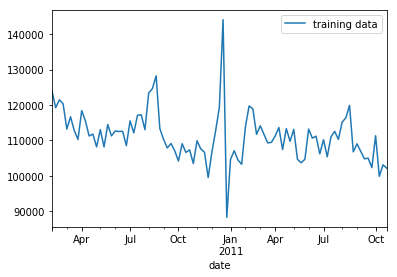

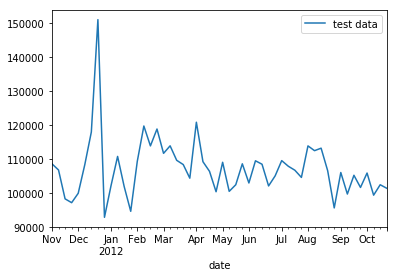

In [4]:
dep2train['date'] = pd.to_datetime(dep2train['date'], format='%Y-%m-%d')
dep2train['fold'] = 'train'
dep2test['date'] = pd.to_datetime(dep2test['date'], format='%Y-%m-%d')
dep2test['fold'] = 'test'

_ = dep2train.plot(y = 'weeklySales', x = 'date', label = 'training data')
_ = dep2test.plot(y = 'weeklySales', x = 'date', label = 'test data')

#### Measure of Prediction Accuracy
We are going to measure the prediction accuracy by mean absolute percentage error (MAPE). You should report MAPE using test data for every question. MAPE is defined as:
$ MAPE = \frac{1}{n} \sum_{i=1}^n |\frac{\hat{y}_t - y_t}{y_t}|,$ where $y_t$ is the actual value of period t and $\hat{y}_t$ is the prediction for period t. 

#### Train-test Split and Expanding Window
A common way to compute prediction error (MAPE) is to use a train-test split. We train a model M1 using the training data and use M1 to make predictions. When doing this, we apply the model and every test record independently and compute the MAPE. This approach, however, may not be reasonable because we can make predictions sequentially when applying to time series models. This is so-called the "Expanding Window" approach. That is, after making a prediction for period 1, we can include the data of period 1 into our training data. When making a prediction for period 2, the model can make use of data in period 1 together with the training data as well. We can optionally re-train the model after predicting for period 1. However, this often takes longer, and we do not re-train the model when making predictions in this homework. That is, when doing the Expanding Window approach, we train the model once using training data. To make predictions, we sequentially apply the model and include test data into training data after the test data point is used to make predictions. 

#### Implementation Restriction
You are allowed to use any Python libraries in your solution.

### Question 1 [Baseline]
(30%) Predict the sales of test data using the mean weekly sales of same week-of-year in training data. Adopt the standard train-test method to compute MAPE. For example to predict the weekly sales of 2011-11-04, we can use the sales records with similar "day of year" or "week of year" in 2010. Since 2011-11-04 is the 307-th day in 2011, you can use the 43-week (307//7) in year 2010 to predict the weekly sales of 2011-11-04. 

You should report (1) the MAPE of the test period, and (2) a plot of test data and their predicted value. 

In [5]:

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [6]:
# calculate day of year
dep2train['woy'] = dep2train['date'].apply(lambda x: x.isocalendar()[1])
dep2test['woy'] = dep2test['date'].apply(lambda x: x.isocalendar()[1])

In [7]:
y_pred = []
for i in dep2test['woy']:
    tmp = np.mean(dep2train['weeklySales'][dep2train['woy'] == i])
    y_pred.append(tmp)
    
y_true = dep2test['weeklySales']

MAPE: 4.359138717038288


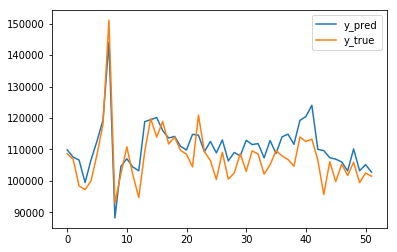

In [8]:
# MAPE
mape = mean_absolute_percentage_error(y_true, y_pred)
print("MAPE:", mape)
plt.plot(y_pred, label = 'y_pred')
plt.plot(y_true, label = 'y_true')
plt.legend()
plt.show()

### Question 2 [Random Forest]
Preidct weekly sales using Random Forest (RF). Consider the two following setting. 
* Q2.1 (15%) $y_t = f(y_{t-1}, y_{t-2}, y_{t-3}, y_{t-4})$. 
* Q2.2 (15%) $y_t = f(y_{t-1}, y_{t-2}, y_{t-3}, y_{t-4}, y_{t-52})$. 

You should use the "Expanding Window" approach when evaluating the prediction accuracy. For each setting, report the MAPE and a plot of true and predicted values. 

#### Q2.1

In [9]:
from sklearn.ensemble import RandomForestRegressor

In [10]:
# reframe to time lagged dataset 
train = dep2train.copy().set_index('date')
df_train = pd.DataFrame()
series = train['weeklySales']
for i in range(4,0,-1):
    df_train['t-'+str(i)] = series.shift(i)
df_train['t'] = series.values
df_train = df_train[4:]

In [11]:
array = df_train.values
# split into input and output
X = array[:,0:-1] # period = t-1 ~ t-4
y = array[:,-1] # period = t

# fit random forest model
model = RandomForestRegressor(n_estimators=500, random_state=1)
model.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=1, verbose=0,
                      warm_start=False)

In [12]:
test = dep2test.copy().set_index('date')[['weeklySales']]
pred = list(df_train[-4:]['t'].values)
y_pred = []

for i in range(52):
    p = model.predict([pred])
    y_pred.append(p[0])
    pred.append(test['weeklySales'][i])
    pred.pop(0)

MAPE: 5.956281314338971


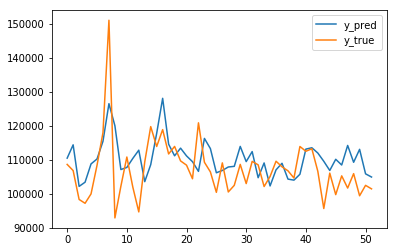

In [13]:
mape2 = mean_absolute_percentage_error(y_true, y_pred)
print("MAPE:", mape2)
plt.plot(y_pred, label = 'y_pred')
plt.plot(y_true, label = 'y_true')
plt.legend()
plt.show()

#### Q2.2

In [14]:
df_train2 = pd.DataFrame()
series = train['weeklySales']
for i in range(52,0,-1):
    df_train2['t-'+str(i)] = series.shift(i)
df_train2['t'] = series.values

df_train2 = df_train2[52:]

In [15]:
array = df_train2[['t-52', 't-4', 't-3', 't-2', 't-1', 't']].values
# split into input and output
X = array[:,0:-1] # period = t-1 ~ t-4
y = array[:,-1] # period = t

# fit random forest model
model = RandomForestRegressor(n_estimators=500, random_state=1)
model.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=1, verbose=0,
                      warm_start=False)

In [16]:
test = dep2test.copy().set_index('date')[['weeklySales']]
tmp = df_train2.values[-1]

y_pred = []

for i in range(52):
    pred = tmp[np.array([1, -4, -3, -2, -1])]
    p = model.predict([list(pred)])
    
    tmp = np.append(tmp, test['weeklySales'][i])
    tmp = tmp[1:]
    
    y_pred.append(p[0])

MAPE: 3.759472610654982


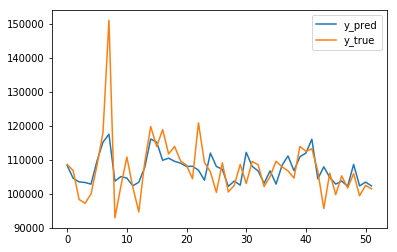

In [17]:
mape3 = mean_absolute_percentage_error(y_true, y_pred)
print("MAPE:", mape3)
plt.plot(y_pred, label = 'y_pred')
plt.plot(y_true, label = 'y_true')
plt.legend()
plt.show()

### Question 3 [Gaussian Process Regression]
Gaussian process regression (GPR) can be used to perform time series prediction. The input feature is simply the "week sequence number." You can construct this week sequence number from the calendar date.  Each week sequence number is paired with its weekly sales. Your Gaussian process regression should have a kernel that contains the sum of an RBF kernel (sklearn.gaussian_process.kernels.RBF), an Exp-Sine-Squared kernel (sklearn.gaussian_process.kernels.ExpSineSquared), and a White noise kernel (sklearn.gaussian_process.kernels.WhiteKernel). The RBF kernel is used to capture near-by relations, the Exp-Sine-Squared kernel is used to capture seasonality, and the White noise kernel is used to model noise. 

* Q3.1 (20%) Normalize the weekly sales using training data so that the training data for GPR have a mean 0 and unit variance, and the test data also have a mean close to zero and a variance close to one. Train your model and make predictions. Be sure to transform the prediction data back to the original scale before computing MAPE. 
* Q3.2 (20%) Repeat Q3.1 but use the original weekly sales instead of the transformed values. 
* Q3.3 (20%) Selected the best model from Q3.1 and Q3.2. Use this model to perform "Expanding Window" approach and compute MAPE. Note that you should do retrain but set the solver to none so that you do not need to reestimate the kernel parameters. 

You should report (1) the MAPE of the test period, and (2) a plot of test data and their predicted value for each of the sub-question. 

#### Q.3.1

In [18]:
from sklearn.preprocessing import StandardScaler
Y = dep2train[['weeklySales']]
scaler = StandardScaler()
scaler.fit(Y)
y = scaler.transform(Y)
X = dep2train[['woy']].values

x_test = dep2test[['woy']].values

In [6]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ExpSineSquared

kernel = RBF() + WhiteKernel() + ExpSineSquared()
gpr1 = GaussianProcessRegressor(kernel=kernel, random_state=0).fit(X, y)

y_pred = scaler.inverse_transform(gpr1.predict(x_test)).ravel()

MAPE: 4.359138717038288


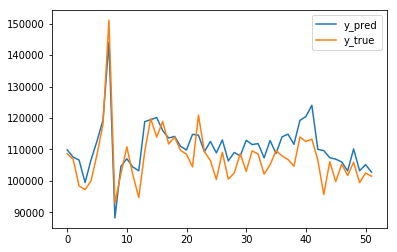

In [9]:
mape4 = mean_absolute_percentage_error(y_true, y_pred)
print("MAPE:", mape4)
plt.plot(y_pred, label = 'y_pred')
plt.plot(y_true, label = 'y_true')
plt.legend()
plt.show()

In [20]:
kernel = RBF() + WhiteKernel() + ExpSineSquared()
gpr1 = GaussianProcessRegressor(kernel=kernel, random_state=0).fit(X, y)

y_pred = scaler.inverse_transform(gpr1.predict(X)).ravel()

In [29]:
print(24 * 7)
print(24 * 14)

168
336


In [26]:
len(x_test)

52

MAPE: 4.359138717038288


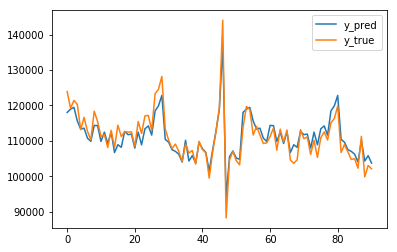

In [23]:
#mape4 = mean_absolute_percentage_error(y_true, y_pred)
print("MAPE:", mape4)
plt.plot(y_pred, label = 'y_pred')
plt.plot(Y, label = 'y_true')
plt.legend()
plt.show()

In [10]:
dep2test[['woy']].values

array([[44],
       [45],
       [46],
       [47],
       [48],
       [49],
       [50],
       [51],
       [52],
       [ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11],
       [12],
       [13],
       [14],
       [15],
       [16],
       [17],
       [18],
       [19],
       [20],
       [21],
       [22],
       [23],
       [24],
       [25],
       [26],
       [27],
       [28],
       [29],
       [30],
       [31],
       [32],
       [33],
       [34],
       [35],
       [36],
       [37],
       [38],
       [39],
       [40],
       [41],
       [42],
       [43]])

#### Q3.2

In [19]:
y = dep2train[['weeklySales']] # without standardize
X = dep2train[['woy']]

x_test = dep2test[['woy']]

kernel = RBF() + WhiteKernel() + ExpSineSquared()
gpr2 = GaussianProcessRegressor(kernel=kernel, random_state=0).fit(X, y)

y_pred = gpr2.predict(x_test).ravel()

MAPE: 99.81066552709889


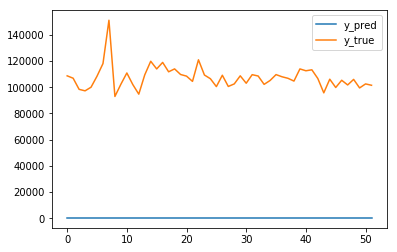

In [20]:
mape5 = mean_absolute_percentage_error(y_true, y_pred)
print("MAPE:", mape5)
plt.plot(y_pred, label = 'y_pred')
plt.plot(y_true, label = 'y_true')
plt.legend()
plt.show()

#### Q3.3

In [21]:
Y = dep2train[['weeklySales']]
scaler = StandardScaler()
scaler.fit(Y)
y = scaler.transform(Y)
X = dep2train[['woy']]
x_test = dep2test[['woy']].values

In [22]:
y_pred = []
kernel = RBF() + WhiteKernel() + ExpSineSquared()
for i in range(52):
    gpr3 = GaussianProcessRegressor(kernel=kernel, random_state=0, optimizer = None).fit(X, y)
    p = gpr3.predict(x_test[i].reshape(1,1))
    y_pred.append(p[0])
    X = X.append({'woy': x_test[i]}, ignore_index=True)
    y = np.append(y, scaler.transform(y_true[i].reshape(1,1)))


In [23]:
y_pred = scaler.inverse_transform(y_pred).ravel()

MAPE: [4.96150223]


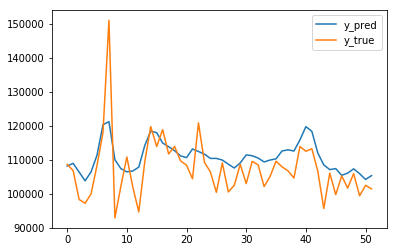

In [24]:
mape6 = mean_absolute_percentage_error(y_true, y_pred)
print("MAPE:", mape6)
plt.plot(y_pred, label = 'y_pred')
plt.plot(y_true, label = 'y_true')
plt.legend()
plt.show()

### Question 4 [Summarize and Discuss]
(10%) Summarize the prediction performance and discuss your findings. 

Random Forest考慮前1,2,3,4,52期（使用Expanding Window）的MAPE表現最好。Gaussian Process表現則不如預期，可能是因為kernel沒有調整所以結果不好，但也驗證了在跑Gaussian Process標準化的重要性。

### Bonus Question 4 [My Prediction Model]
(20%) This is a bonus question. Develop your own method. Your method should be different from the methods in Questions 1 to 3. Moreover, your method should deliver a MAPE that is better than the baseline model. 

#### Try My Prediction Model 1

In [28]:
start = dep2train[(dep2train['woy'] == 44)]['date'].values[0]
y_pred = dep2train[(dep2train['date'] >= start)]['weeklySales'].reset_index(drop=True)
y_true = dep2test['weeklySales'].reset_index(drop=True)

MAPE: 3.657097713947293


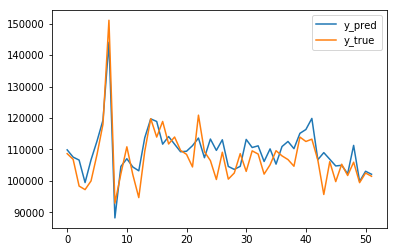

In [29]:
mymape1 = mean_absolute_percentage_error(y_true, y_pred)
print("MAPE:", mymape1)
plt.plot(y_pred, label = 'y_pred')
plt.plot(y_true, label = 'y_true')
plt.legend()
plt.show()

我使用了前一年同期的WeeklySales作為預測，結果其實不差（Baseline是取歷史資料每年同一週平均，我是只取前一年同一週）

#### Try My Prediction Model 2: Xgboost

In [30]:
import xgboost as xgb

In [31]:
array = df_train2[['t-52', 't-4', 't-3', 't-2', 't-1', 't']].values
# split into input and output
X = array[:,0:-1] # period = t-1 ~ t-4
y = array[:,-1] # period = t

# fit random forest model
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X, y)

[00:33:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [32]:
test = dep2test.copy().set_index('date')[['weeklySales']]
tmp = df_train2.values[-1]

y_pred = []

for i in range(52):
    pred = tmp[np.array([1, -4, -3, -2, -1])]
    p = xgb_model.predict([list(pred)])
    
    tmp = np.append(tmp, test['weeklySales'][i])
    tmp = tmp[1:]
    
    y_pred.append(p[0])

MAPE: 4.072503159987216


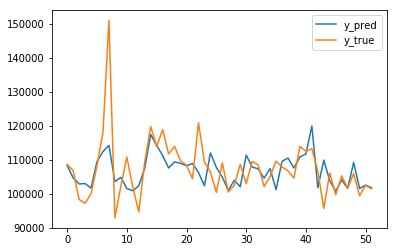

In [33]:
mymape2 = mean_absolute_percentage_error(y_true, y_pred)
print("MAPE:", mymape2)
plt.plot(y_pred, label = 'y_pred')
plt.plot(y_true, label = 'y_true')
plt.legend()
plt.show()

試了xgboost跑 $y_t = f(y_{t-1}, y_{t-2}, y_{t-3}, y_{t-4}, y_{t-52})$.，結果稍微比Baseline好，但Random Forest跑結果比較好